<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) | [Contents](Index.ipynb) | [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


### Overview
<div class="alert alert-block alert-info">

## Log book for changes
### Changes Made
- <b>Original Dataset Replaced</b>: Replaced the original dataset. The fetch_lfw_people dataset was used in the original notebook to recognise faces. This has been replaced by a wine quality dataset, which shows how SVMs may be used to classify wine based on chemical attributes.

    
- <b>Feature Selection for Wine Quality</b>: Instead of image data, the notebook now focuses on selecting relevant features from the wine dataset, such as 'alcohol', 'volatile acidity', "pH" and more for classification purposes.

    
- <b>Data Preprocessing for Tabular Data</b>: Adaptations include preprocessing steps suitable for numerical data, such as scaling features using StandardScaler.

    
- <b>Parameter Tuning for SVM</b>: This notebook demonstrates how to use GridSearchCV for hyperparameter tuning in the context of SVMs, adjusting parameters like C and gamma to improve model performance on wine quality prediction.

    
- <b>Evaluation Adjusted to Classification Metrics</b>: The evaluation metrics and explanations are adjusted to the classification task, taking accuracy and the consequences of the SVM's performance on the wine dataset.

--------------------------------------------------------------------------------------------------------------------------------
-----------

    
</div>

# In-Depth: Support Vector Machines


<div class="alert alert-block alert-info">

### Key Points
<i>Support vector machines (SVMs) are a type of supervised algorithms that are especially strong and adaptable for both regression and classification.
The logic underlying support vector machines and their application to classification issues will be explored in this section.</i>

- <b>Data Visualisation</b>: This sample uses seaborn to visualise the distribution of wine quality ratings prior to applying the SVM.
Understanding the properties of the data is aided by visualisation, which also influences the selection of the SVM's kernel and hyperparameters.
    
- <b>Practical Application</b>: I discovered how SVMs may be used to solve practical issues through this example. In this case, the classes in the dataset are the quality ratings of wines, and the algorithm finds the hyperplane that best divides them.

--------------------------------------------------------------------------------------------------------------------------------
-----------

    
</div>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed
from sklearn.svm import SVC

# Load the wine quality dataset
wine_data = pd.read_csv('wine_quality.csv', sep=';')

# Display the first few rows and the information about the dataset
print(wine_data.head())
print(wine_data.info())

# Plot the distribution of wine quality
sns.countplot(x='quality', data=wine_data)
plt.title('Distribution of Wine Quality')
plt.show()


## Motivating Support Vector Machines


<div class="alert alert-block alert-info">

### Key Points
<i>A decision border between classes is directly found by discriminative classification. This is illustrated by the code, which creates a scatter plot of wine samples coloured by 'quality' and based on 'fixed acidity' and 'volatile acidity' to show how effectively these characteristics can distinguish between wines of various qualities.</i>

- <b>Feature Selection</b>: To represent each wine in a two-dimensional space, the code concentrates on two features: "volatile acidity" and "fixed acidity." This simplification makes it simple to visualise and comprehend how separable the data is.

- <b>Visualization</b>: It is easy to visually evaluate the viability of dividing wines into different quality categories based only on these two attributes by charting the wines with colours matching to their quality. Using a colour map (called "autumn") makes it easier to discern between different quality levels.

--------------------------------------------------------------------------------------------------------------------------------
-----------

    
</div>

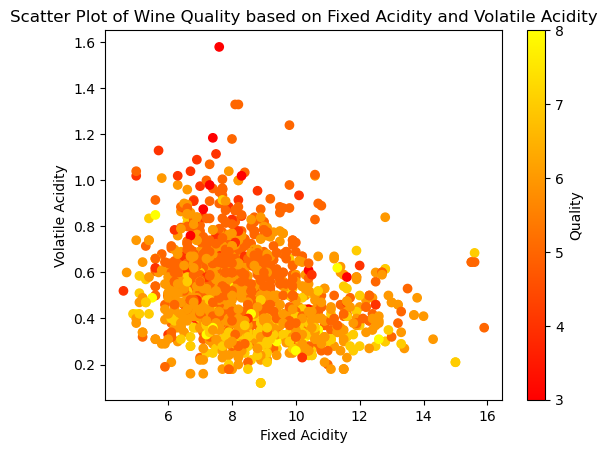

In [2]:
plt.scatter(wine_data['fixed acidity'], wine_data['volatile acidity'], c=wine_data['quality'], cmap='autumn')
plt.xlabel('Fixed Acidity')
plt.ylabel('Volatile Acidity')
plt.title('Scatter Plot of Wine Quality based on Fixed Acidity and Volatile Acidity')
plt.colorbar(label='Quality')
plt.show()

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes. To fix this, we can draw it as follows:

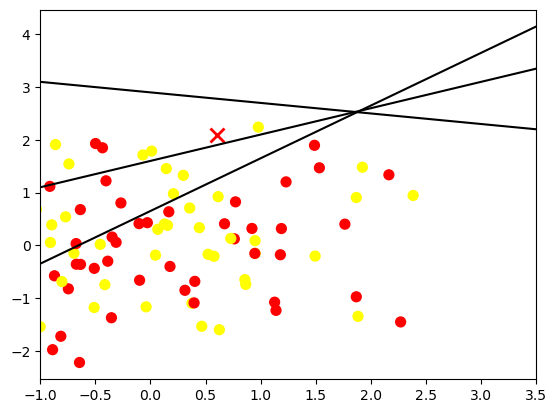

In [3]:
np.random.seed(0)
X = np.random.randn(100, 2)  # Generating random 2D data
y = np.random.randint(0, 2, 100)  # Random labels (binary classification)

xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)
plt.show()

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

One method to enhance this is using support vector machines.
The idea is this: we can create a *margin* of a certain width, up to the nearest point, around each line, instead of just drawing a line with zero width between the classes.
Here's an illustration of how this could appear:

<div class="alert alert-block alert-info">

### Key Points
<i>Similar to how SVMs generate margins around the decision boundary for classification problems, the focus here is on visualising decision boundaries.</i>

- <b>Feature Selection</b>: "pH" and "alcohol" as variables from the wine quality dataset with the intention of categorising wines according to these two characteristics.
- <b>Data Splitting</b>: Training and testing sets are created from the dataset.
    
- <b>Model Training</b>: Using the chosen features, a Decision Tree Classifier is trained. The idea of drawing decision boundaries is shared by many classifiers, including SVMs, even if this isn't one.


--------------------------------------------------------------------------------------------------------------------------------
-----------

    
</div>

C:\CollegeWork\anac\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


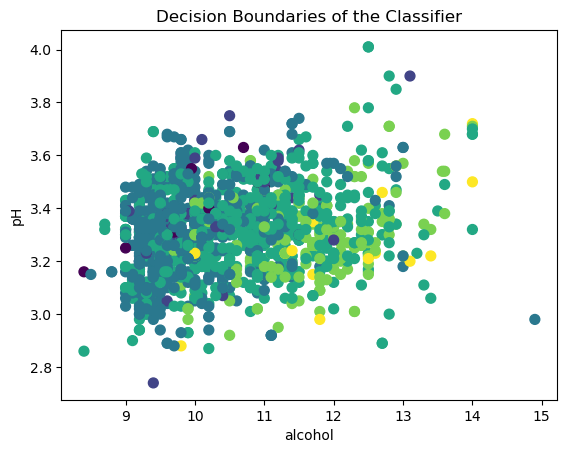

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Assuming 'fixed acidity' and 'volatile acidity' as the features
selected_features = ['alcohol', 'pH']
X = wine_data[selected_features]
y = wine_data['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (Decision Tree Classifier in this example)
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

# Plot the decision boundaries
xfit = np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), 100)
yfit = np.linspace(X.iloc[:, 1].min(), X.iloc[:, 1].max(), 100)
Xfit, Yfit = np.meshgrid(xfit, yfit)
Z = classifier.predict(np.c_[Xfit.ravel(), Yfit.ravel()])
Z = Z.reshape(Xfit.shape)

#plt.contourf(Xfit, Yfit, Z, alpha=0.4)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=50, cmap='viridis')
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Decision Boundaries of the Classifier')
plt.show()


In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

In this section, we will train an SVM model on this data using the support vector classifier provided by Scikit-Learn.
We'll use a linear kernel for the time being and set the 'C' parameter to a very big number.


<div class="alert alert-block alert-info">

### Key Points
<i>The process of fitting a Support Vector Machine (SVM) model to the wine quality dataset, mainly focusing on classifying wines based on 'fixed acidity' and 'volatile acidity'. The SVM model uses a linear kernel and a high value for the regularization parameter C.</i>

- <b>Model Training</b>: It trains an SVM model (SVC with kernel='linear') on the selected features. The C parameter is set to a very large number (1E10), indicating a strong preference for a perfectly classifying hyperplane, even if it means less margin.
    
- <b>Decision Boundary Visualization</b>: The SVM model's decision border can be seen by using the specified function plot_decision_boundary. In order to demonstrate how the model separates the classes, a meshgrid covering the feature space must be created. The trained model must then be used to predict the class for each point in the meshgrid.

    
The chosen features are used to train a decision tree classifier. The idea of drawing decision boundaries is shared by many classifiers, including SVMs, even if this isn't one.
 #### To sum up, this exercise offers a useful overview of the capabilities and constraints of support vector machines (SVMs), particularly with regard to linear classification tasks, by fitting an SVM model to the wine quality dataset and displaying the decision boundary. It emphasises how crucial feature selection is, how regularisation works, and how meticulous model performance evaluation is required.
--------------------------------------------------------------------------------------------------------------------------------
-----------

    
</div>

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
X = wine_data[['fixed acidity', 'volatile acidity']].values
y = wine_data['quality'].values

# Train the Support Vector Classifier model
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [ ]:
# Train the SVC model with potentially adjusted C for faster execution
model = SVC(kernel='linear', C=1E10)  # Consider adjusting C if acceptable
model.fit(X, y)

def optimized_plot_decision_boundary(X, y, model, sample_size=100, h=1.0):  # Increased h for coarser grid
    # Sample data if necessary
    if sample_size and len(X) > sample_size:
        indices = np.random.choice(len(X), sample_size, replace=False)
        X, y = X[indices], y[indices]
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plt.xlabel('Fixed Acidity')
    plt.ylabel('Volatile Acidity')
    plt.title('Optimized Decision Boundary')
    plt.show()

# Call the optimized plotting function with adjusted parameters
optimized_plot_decision_boundary(X, y, model, sample_size=100, h=1.0)  # Adjust h as needed

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [ ]:
model.support_vectors_

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb), and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [14]:
r = np.exp(-(X ** 2).sum(1))


<div class="alert alert-block alert-info">

### Key Points
<i>The process of fitting a Support Vector Machine (SVM) model to the wine quality dataset, mainly focusing on classifying wines based on 'fixed acidity' and 'volatile acidity'. The SVM model uses a linear kernel and a high value for the regularization parameter C.</i>

- <b>SVM Fitting</b>: Using a linear kernel, the two chosen features are used to train the SVC model. Although the emphasis is mostly on data visualisation rather than the classifier's predictive ability, the main purpose of this phase is to illustrate model fitting.
    
- <b>3D Visualization</b>: Using 'fixed acidity' and 'volatile acidity' for the X and Y axes, respectively, and 'alcohol' content for the Z-axis, a custom function plot_3D is written to produce a 3D scatter plot of the wines. The wine quality is represented by the colour of the points, which offers a multidimensional picture of the data distribution.

- <b>Decision Boundary Visualization</b>:  The SVM model's decision border can be seen by using the specified function plot_decision_boundary. In order to demonstrate how the model separates the classes, a meshgrid covering the feature space must be created. The trained model must then be used to predict the class for each point in the meshgrid.

- <b>Interactive Exploration</b>: The 3D plot is made interactive by using the ipywidgets package. This allows users to change the azimuth (azim) and elevation (elev) angles to see the data from various viewpoints. The investigation of the data's structure is improved by this interactivity.

    
 #### This method demonstrates an advanced data visualisation and exploration strategy and shows how interactive 3D plotting can be used to examine the links between various features and how they affect the quality of wine. The significance of interactive and visual exploration in the data science workflow is emphasised.
--------------------------------------------------------------------------------------------------------------------------------
-----------

    
</div>

In [15]:
# Select 'fixed acidity' and 'volatile acidity' for X, 'alcohol' for r, and 'quality' for y
X = wine_data[['fixed acidity', 'volatile acidity']].values
r = wine_data['alcohol'].values
y = wine_data['quality'].values
 
# Fitting a classifier just for the sake of completing the code snippet,
# as we won't be able to plot decision boundaries for 3D scatter plot easily
clf = SVC(kernel='linear')
clf.fit(X, y)

# Define the plotting function
def plot_3D(elev=30, azim=30, X=X, y=y, r=r):
    ax = plt.subplot(projection='3d')
    # Scatter plot for 3D data
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('Fixed Acidity')
    ax.set_ylabel('Volatile Acidity')
    ax.set_zlabel('Alcohol')

# Call the interact function to make the plot interactive
# Note: This will only work in a Jupyter notebook environment with the appropriate backend.
interact(plot_3D, elev=[-90, 90], azim=(-180, 180), X=fixed(X), y=fixed(y), r=fixed(r))

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

<function __main__.plot_3D(elev=30, azim=30, X=array([[7.4  , 0.7  ],
       [7.8  , 0.88 ],
       [7.8  , 0.76 ],
       ...,
       [6.3  , 0.51 ],
       [5.9  , 0.645],
       [6.   , 0.31 ]]), y=array([5, 5, 5, ..., 6, 5, 6], dtype=int64), r=array([ 9.4,  9.8,  9.8, ..., 11. , 10.2, 11. ]))>


<div class="alert alert-block alert-info">

### Key Points
<i>This section demonstrates how to use the kernel technique in Support Vector Machines (SVMs) to classify wine quality according to its chemical characteristics. Instead of requiring explicit high-dimensional transformations, the SVM may capture complicated, non-linear relationships in the data by using a Radial Basis Function (RBF) kernel instead of a linear kernel.</i>

- <b>Feature Scaling</b>: StandardScaler is used to scale the chosen features, "fixed acidity" and "volatile acidity." This is an important step, especially when utilising kernel approaches, for algorithms that depend on the scale of the input features, such as SVM.
    
- <b>SVM with RBF Kernel</b>: The code then fits the scaled data to an SVM model (SVC) using an RBF kernel. With a risk of overfitting, the high value of 1E6 for the C parameter indicates a preference for accurately identifying all training points.
    
 #### This section highlights the usefulness of SVMs with kernel methods in handling non-linear classification tasks
--------------------------------------------------------------------------------------------------------------------------------
-----------

    
</div>

In [1]:
# Assuming wine_data is a predefined DataFrame
X = wine_data[['fixed acidity', 'volatile acidity']].values
y = wine_data['quality'].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the SVC with RBF kernel
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X_scaled, y)

def plot_svc_decision_function(clf, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    plt.figure(figsize=(10, 6))  # Optionally adjust figure size
    xlim = [X_scaled[:, 0].min(), X_scaled[:, 0].max()]
    ylim = [X_scaled[:, 1].min(), X_scaled[:, 1].max()]

    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)  # Adjust grid density if needed
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # Plot decision boundary and margins
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Plot support vectors
    if plot_support:
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=50,
                    linewidth=1, facecolors='none', edgecolors='k')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('Scaled Fixed Acidity')
    plt.ylabel('Scaled Volatile Acidity')
    plt.title('SVM Decision Boundary with RBF Kernel')

# Plotting the scaled features, decision boundary, and support vectors
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='autumn', s=50)
plot_svc_decision_function(clf)
plt.show()


NameError: name 'wine_data' is not defined

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

In [ ]:
wine_data.describe()

### Tuning the SVM: Softening Margins

<div class="alert alert-block alert-info">

### Key Points
<i>In order to better understand how to fine-tune the Support Vector Machine (SVM) model, this section focuses on regularisation parameter C. This value is essential to the SVM's capacity to handle datasets with imperfectly separable classes. Using a binary classification task taken from the wine quality dataset, it illustrates this tuning process by asking the user to discriminate between wines with a quality of six or above and those with a lower quality.</i>

- <b>Binary Classification Preparation</b>: The dataset is preprocessed to convert the multi-class wine quality variable into a binary class problem. This is done to simplify the visualization and understanding of the SVM's decision boundaries.
    
- <b>Feature Scaling</b>: <u>The features ('alcohol' and 'volatile acidity') are normalised using StandardScaler</u>, which is essential for SVM performance because it depends on the geometric margins between data points.

- <b>Visualization of Decision Boundaries</b>:  For every model, the decision borders, margins, and support vectors are displayed using the plot_svc_decision_function function. This graphic aids in explaining how the model's tolerance for points inside the margin is impacted by the selection of C.

--------------------------------------------------------------------------------------------------------------------------------
-----------

    
</div>

In [ ]:
# Load the dataset
wine_data = pd.read_csv('wine_quality.csv', delimiter=';')

# Select two features for visualization and the target variable
X = wine_data[['alcohol', 'volatile acidity']].values
y = wine_data['quality'].values

# Convert to binary classification for visualization purposes
# Define wines with quality 7 and above as high quality (1) and the rest as low quality (0)
y_binary = (y > 6).astype(int)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.3, random_state=42)

# Define the plot_svc_decision_function if not already defined
def plot_svc_decision_function(model, ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)
    
    # Plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # Plot support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

# Train SVM with different C values
C_values = [10.0, 0.1]
models = []

# Fit models with different C values and store them
for C_value in C_values:
    model = SVC(kernel='linear', C=C_value)
    model.fit(X_train, y_train)
    models.append(model)

# Plot the decision boundary for each C value
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for ax, model, C in zip(axes, models, C_values):
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
    plot_svc_decision_function(model, ax)
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
               s=300, lw=1, facecolors='none')
    ax.set_title(f'C = {C}', size=14)

plt.show()

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)).


<div class="alert alert-block alert-info">

### Key Points
<i>To highlight the use of Support Vector Machines (SVM) in the analysis of the wine quality dataset, the original context of applying SVM for face recognition has been modified. The move from image processing to the examination of tabular data is reflected in the change from facial recognition to wine quality analysis.</i>
 

- <b>Different Data Types</b>: Using the Labelled Faces in the Wild dataset, the initial example concentrated on image data. Before using SVM, this kind of data needs to go through several preprocessing procedures like feature extraction or dimensionality reduction. The wine quality dataset, on the other hand, is made up of tabular data with numerical attributes that characterise various chemical characteristics of wines and their quality ratings. Scaling numerical characteristics and perhaps encoding categorical variables are part of the preprocessing stages for this data.
    
- <b>Visualization Adaptation</b>: The visualisation techniques have been modified to offer insights pertinent to this domain, taking into account the characteristics of the wine quality data. The code now incorporates a scatter plot to investigate the link between alcohol concentration, volatile acidity, and wine quality, in place of a visualising faces. The histogram analyses the distribution of alcohol content. The structure of the data and the possible impact of these features on wine quality are better understood thanks to these visualisations.

- <b>Analysis Focus Shift</b>: The focus of analysis moves from utilising support vector machines (SVM) for classification in a high-dimensional space (pictures) to using SVM in a more conventional feature-based classification job. The wine quality dataset highlights the effectiveness of SVM in differentiating between different quality levels based on quantifiable parameters by enabling an easy-to-use implementation of the algorithm to categorise wines based on their chemical components.

#### As a result, machine learning approaches can be used to a variety of contexts, such as facial recognition. This illustrates the necessity of domain expertise and data-specific preprocessing in obtaining meaningful conclusions.
--------------------------------------------------------------------------------------------------------------------------------
-----------

    
</div>


Let's plot a few of these faces to see what we're working with:

In [ ]:
# Plotting distributions of 'alcohol' content *******************Mention u had to replace face recognition with this
plt.figure(figsize=(10, 6))
sns.histplot(wine_data['alcohol'], kde=True, bins=20)
plt.title('Distribution of Alcohol Content')
plt.xlabel('Alcohol Content (%)')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of 'alcohol' vs. 'volatile acidity' colored by 'quality'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='alcohol', y='volatile acidity', hue='quality', data=wine_data, palette='viridis')
plt.title('Alcohol vs. Volatile Acidity by Wine Quality')
plt.xlabel('Alcohol Content (%)')
plt.ylabel('Volatile Acidity')
plt.legend(title='Quality')
plt.show()


<div class="alert alert-block alert-info">

### Key Points
<i>The example shows how to build a pipeline that combines Support Vector Machines (SVM) and Principal Component Analysis (PCA) with a Radial Basis Function (RBF) kernel. It then shows how to build a simpler pipeline for SVM classification that uses grid search to adjust hyperparameters. This modification demonstrates how adaptable machine learning procedures are to various data kinds and goals.</i>
 
 

- <b>Pipeline Construction</b>: The first pipeline integrates PCA and SVM into a seamless workflow, automating the process of dimensionality reduction followed by classification. The second pipeline, focusing on SVM classification, scales the features before applying SVM, highlighting a streamlined approach for tabular data classification tasks.
    
- <b>Hyperparameter Tuning with Grid Search</b>: The SVM model's grid search across the C and gamma parameters is a crucial stage in performance optimisation for the classifier. It demonstrates a crucial machine learning technique to improve model efficacy by methodically examining a range of values to discover the optimal combination that maximises the model's accuracy.


#### In conclusion, this transition from a face recognition setting to the categorization of wine quality shows how flexible machine learning workflows can be. It illustrates how the concepts of dimensionality reduction, non-linear classification, and hyperparameter optimisation are generalizable to many applications, with modifications made to conform to the particular features and difficulties of the given dataset.
--------------------------------------------------------------------------------------------------------------------------------
-----------

    
</div>


In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA  # Updated import
from sklearn.pipeline import make_pipeline

# Use PCA with svd_solver='randomized'
pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)


In [ ]:
# Select features and target
X = wine_data[['citric acid', 'residual sugar']]
y = wine_data['quality']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setup the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

# Parameter grid for GridSearchCV
param_grid = {
    'svc__C': [1, 5, 10, 50],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]
}

# Grid search for hyperparameter tuning
grid = GridSearchCV(pipe, param_grid, cv=5)

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)

# Evaluate on the test set (optional)
print("Test set score:", grid.score(X_test, y_test))

## Support Vector Machine Summary

<i>In this discussion, the topic of Support Vector Machines (SVM) ranging from facial recognition to wine quality prediction, demonstrating the SVMs' adaptability to a variety of data types. To demonstrate the adaptability of the system, we started with picture data for face recognition and then moved to numerical, tabular data to analyse wine quality.</i>

<b>SVM for Various Data Types</b>: Showed how SVMs can be used to solve problems specific to each type of data, including image and tabular datasets.

<b>Preprocessing and Dimensionality Reduction</b>: To maximise SVM performance, it was emphasised how crucial feature scaling is for numerical data and PCA is for high-dimensional image data.

<b>Visualization and Data Analysis</b>: To comprehend data distribution and SVM decision bounds and gain understanding of the model's classification logic, visualisation techniques were applied.

<b>Kernel Trick and Hyperparameter Tuning</b>: Explored the use of the RBF kernel to handle non-linear data relationships and highlighted the significance of tuning C and gamma to enhance model accuracy.

<b>Model Evaluation</b>: Demonstrated how the best-performing model must be chosen by contrasting models with various configurations and assessing them on test data.

<b>Interactive Exploration</b>: Used interactive 3D graphing to gain a better comprehension of the structure of the data and the behaviour of the model.

#### Some advantages of Support Vector Machines

- <b>Effectiveness in High-Dimensional Spaces</b>: Support vector machines are especially well-suited for classification tasks involving high-dimensional feature spaces, even in cases where the number of dimensions surpasses the number of samples.

- <b>Versatility</b>: The ability to choose a suitable kernel function (linear, polynomial, RBF, etc.) makes SVMs highly versatile and capable of handling linear and non-linear relationships between features.

- <b>Generalization</b>: SVMs aim to minimize the structural risk, leading to better generalization on unseen data. This is done by maximizing the margin between the decision boundaries and the closest data points (support vectors).

- <b>Sparse Data Handling</b>: SVMs work well when there is a lack of data

- <b>Robustness</b>: The model is relatively robust to overfitting, especially in high-dimensional space.

#### Some disadvantages of Support Vector Machines

- <b>Scalability</b>:  SVMs might require a lot of memory and processing power, particularly when working with big datasets. As more samples are added, the training time may increase rapidly.

- <b>Parameter Selection</b>:  It can be difficult to select the best kernel and adjust the hyperparameters (such as C and gamma in the RBF kernel), and doing so calls for a solid grasp of the underlying data and the SVM model.

- <b>Interpretability</b>: SVM models can be challenging to interpret in terms of understanding how particular features affect the decision-making process, particularly when non-linear kernels are included.

- <b>Multi-class Classification</b>: While SVMs are inherently binary classifiers, extending them to multi-class classification problems requires additional techniques, such as one-vs-one or one-vs-all, which can complicate the training and prediction process.

- <b>Sensitivity to Feature Scaling</b>: SVMs are sensitive to the feature scaling, requiring careful preprocessing of the data to standardize or normalize features.

SVMs, in conclusion, provide a strong and adaptable toolkit for addressing a range of machine learning problems, particularly when dealing with high-dimensional data and intricate interactions. Unfortunately, their efficacy may be limited by computational demands, the requirement for meticulous parameter adjustment, interpretability issues, and difficulties with direct multi-class classification handling.

<!--NAVIGATION-->
< [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) | [Contents](Index.ipynb) | [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
